<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/main/%C3%9Cbung_RNN_L%C3%B6sung_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung 7 - Rekurrente neuronale Netze (RNNs)

## In dieser Übung ...
... beschäftigen wir uns mit rekurrenten neuronalen Netzen, die unter anderem für die Textvorhersage (`text prediction`) eingesetzt werden können. Sie werden ein eigenes Modell zur Vorhersage weiterer Buchstaben (Zeichen) zu einer gegebenen Buchstabensequenz erstellen.

Dazu werden Sie die drei aus der Vorlesung bekannten Varianten von RNNs (Standard, LSTM und GRU) mit Keras implementieren und die Genauigkeit (Accuracy) der Netze miteinander vergleichen.


## 7.0 Vorbereitung

In diesem Abschnitt müssen Sie nichts programmieren! 🎉

Wir haben bereits alle notwendigen Imports für diese Übung hinzugefügt, sodass Sie direkt starten können. Sie müssen lediglich die GPU Unterstützung in Google Colab aktivieren.

**Ihre Aufgaben**

(1) Aktivieren Sie bitte die GPU Unterstützung in Google Colab. Wechseln Sie unter dem Reiter `Laufzeit` -> `Laufzeittyp ändern` von `None` auf `GPU` und bestätigen Sie diese Änderung.

(2) Führen Sie den folgenden Codezelle aus, um die erforderlichen Bibliotheken zu importieren und die GPU Unterstützung zu prüfen. 

  * Hinweis: Wenn Sie dieses Notebook mit dem Direktlink von GitHub geöffnet haben, wird bei der erstmaligen Ausführung eine Warnung angezeigt. Diese müssen Sie durch den Klick auf `Trotzdem ausführen` bestätigen. 

In [1]:
# Import everything needed for this exercise 
import tensorflow as tf
import keras
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from termcolor import colored
import json
import os
import re

print(f"Keras Version: {keras.__version__}; Tensorflow version: {tf.__version__}; NumPy version: {np.__version__}; Python version: ", ".".join(str(x) for x in sys.version_info[:3]))

# Init TPU
if 'COLAB_TPU_ADDR' in os.environ and len(os.environ['COLAB_TPU_ADDR']) > 0:
    tf.keras.backend.clear_session()
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

# Reset random number generators
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

# Check GPU support
print("\n", "-"*15, "DEVICE SUPPORT", "-"*15)
from tensorflow.python.client import device_lib
physical_devices = device_lib.list_local_devices()
print("You are using", len(physical_devices), "physical devises.", len([x for x in physical_devices if x.device_type == "GPU"]), "are GPUs")
for i, d in enumerate(physical_devices):
    print("  ->Physical Device", i+1, "is a", d.device_type, "=>", d.physical_device_desc if len(d.physical_device_desc) > 0 else d.name)

logical_devices = tf.config.list_logical_devices()
print("You are using", len(logical_devices), "logical  devises.", len([x for x in logical_devices if x.device_type == "TPU"]), "are TPUs")
for i, d in enumerate(logical_devices):
    print("  ->Logical  Device", i+1, "is a", d.device_type, "=>", d.name)
print("-"*15, "DEVICE SUPPORT", "-"*15, "\n")

uses_gpu = not len([x for x in physical_devices if x.device_type == "GPU"]) == 0
uses_tpu = not len([x for x in logical_devices if x.device_type == "TPU"]) == 0

if uses_tpu:
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
    strategy = None

if not uses_gpu and not uses_tpu:
    raise Exception("Please enable GPU or TPU support before using this notebook. See here: [Runtime] -> [Change runtime type]")    

print("🎉🎉🎉 You are ready to go! 🎉🎉🎉")  

Keras Version: 2.4.3; Tensorflow version: 2.4.1; NumPy version: 1.19.5; Python version:  3.7.10
INFO:tensorflow:Initializing the TPU system: grpc://10.28.176.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.176.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



 --------------- DEVICE SUPPORT ---------------
You are using 1 physical devises. 0 are GPUs
  ->Physical Device 1 is a CPU => /device:CPU:0
You are using 12 logical  devises. 8 are TPUs
  ->Logical  Device 1 is a CPU => /device:CPU:0
  ->Logical  Device 2 is a TPU => /job:worker/replica:0/task:0/device:TPU:7
  ->Logical  Device 3 is a TPU => /job:worker/replica:0/task:0/device:TPU:6
  ->Logical  Device 4 is a TPU => /job:worker/replica:0/task:0/device:TPU:5
  ->Logical  Device 5 is a TPU => /job:worker/replica:0/task:0/device:TPU:4
  ->Logical  Device 6 is a TPU => /job:worker/replica:0/task:0/device:TPU:3
  ->Logical  Device 7 is a TPU_SYSTEM => /job:worker/replica:0/task:0/device:TPU_SYSTEM:0
  ->Logical  Device 8 is a CPU => /job:worker/replica:0/task:0/device:CPU:0
  ->Logical  Device 9 is a XLA_CPU => /job:worker/replica:0/task:0/device:XLA_CPU:0
  ->Logical  Device 10 is a TPU => /job:worker/replica:0/task:0/device:TPU:0
  ->Logical  Device 11 is a TPU => /job:worker/replica:0/

INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


🎉🎉🎉 You are ready to go! 🎉🎉🎉


## 7.1 One Hot Kodierung

Wir haben in der Vorlesung die One Hot Kodierung (1-aus-n-Code) kennen gelernt. Diese ermöglicht es Zeichen eines Alphabets als Vektoren darzustellen. 

Für ein Alphabet mit `n` einzigartigen Zeichen wird ein Vektor der Länge `n` benötigt. Jedes einzigartige Zeichen wird hierbei als Einheitsvektor definiert. Eine Zeichensequenz mit `m` Zeichen werden als `m` Vektoren mit jeweils der Länge `n` dargestellt.  

**Hinweis** Die vorliegende Implementierung ist für den Umgang mit Zeichen außerhalb des Alphabets konzipiert. Deshalb wird zur Darstellung eines Alphabets mit `n` einzigartigen Zeichen ein Vektor der Länge `n+1` erstellt. Alle Zeichen außerhalb des Alphabets werden durch das `unknown_token` ersetzt. 

Für das Training unseres Netzes werden wir die One Hot Kodierung zur Umwandlung eines Textes in Trainingsdaten nutzen. (Aufgabe 7.2)

* Hinweis: Für weitere Informationen zur One Hot Kodierun schlagen Sie diese in der Vorlesung nach oder benutzen Sie das [Internet](https://de.wikipedia.org/wiki/1-aus-n-Code).

In [2]:
class OneHot(object):
    def __init__(self, tokens, unknown_token = "[UNKNOWN]"):
        '''
        tokens: The tokens you want to be able to encode and decode
        unknown_token: The token to be used when decoding and the net wants to use a not known char
        '''
        self.tokens = tokens
        self.unknown_token = unknown_token
        # Store a bidirectional dictionary containing the characters
        self.char_to_index = dict((token, i + 1) for i, token in enumerate(self.tokens))
        self.index_to_char = dict((i + 1, token) for i, token in enumerate(self.tokens))
        pass

    def encode(self, text_as_tokens, dtype=np.bool_):
        '''
        text_as_tokens: List of tokens
        '''
        # Create the encoding matrix
        enc = np.empty((len(text_as_tokens), len(self.tokens) + 1), dtype=dtype)
        for i, token in enumerate(text_as_tokens):
            # Encode every char
            enc[i] = self.encode_token(token=token, l=len(self.tokens) + 1, dtype=dtype)
        return enc
    
    def encode_token(self, token, l, dtype=np.bool_):
        '''
        token: Single token
        l: length of array to be returned. At position zero it is stored if the char is unknown
        '''
        ret = np.zeros((1, l), dtype=dtype)
        if token not in self.char_to_index:
            ret[0, 0] = 1
        else:
            ret[0, self.char_to_index[token]] = 1
        return ret
    
    def decode(self, mat, unknown_token=None):         
        '''
        mat: matrix to be decoded. Has to be of shape (len_of_text, vocab_size)
        unknown_token: Unknown token. If none uses the one from __init__
        '''
        return [self.decode_token(mat[x]) for x in range(mat.shape[0])]
    
    def decode_token(self, vec, unknown_token=None):
        '''
        vec: Vector that should be decoded. Has to be on vocab length
        unknown_token: Unknown token. If none uses the one from __init__
        '''
        if unknown_token is None:
            unknown_token = self.unknown_token
        if isinstance(vec, tf.Tensor):
            vec = vec.numpy()
        if isinstance(vec, np.ndarray):
            # Use argmax since this will be used in the model created later
            am = np.argmax(vec)
        else:
            am = vec
        if am == 0:
            return unknown_token
        return self.index_to_char[am]

**Ihre Aufgaben**

(1) Untersuchen Sie gegebene Klasse zur One Hot Kodierung und die Funktion der einzelnen Methoden. 

(2) Erstellen Sie für das folgendes Alphabet `HWedlor` eine Instanz der Klasse `OneHot`. 

(3) Kodieren Sie nun die Zeichenfolge `Hello World!` mit der One Hot Kodierung. Wie wird das Zeichen `H` dargestellt? Geben Sie die Dimensionen des Vektors an.

* Hinweis: Sie können zur Umwandlung des Strings in eine Liste von Zeichen die Funktion `tokenize` verwenden. Dies ist aber nicht zwingend erforderlich, da Python den String automatisch als Liste interpretieren kann.

> <Antwort hier einfügen>

> **Musterlösung:** Das Zeichen `H` wird als Vektor `[0 1 0 0 0 0 0 0]` 
dargestellt. Die Dimension ist `1x8`.

(4) Wandeln Sie die kodierte Zeichenfolge zurück in einen für Menschen lesbaren Text. Entspricht der zurückgewandelte Text dem ursprünglichen Input? Falls nicht, beschreiben Sie die Ursache.

* Hinweis: Für eine schönere Ausgabe kann der enkodierte Text mit der Funktion `untokenize` in einen String gewandelt werden.

> <Antwort hier einfügen>

> **Musterlösung:** Der ursprüngliche Text und der kodierte und dekodierte Text ist nicht mehr identisch, da zwei Zeichen (Leerzeichen, Ausrufezeichen) nicht im Alphabet vorhanden sind. Durch Hinzufügen dieser Zeichen ins Alphabet würde man den ursprünglichen Text erhalten.

In [3]:
def tokenize(text):
    """
    Converts the given text (string) in a list of blocks of two chars.
    """
    n = 2
    return [text[i:i+n] for i in range(0, len(text)-n, n)] # re.split('([^a-zA-Z0-9])', text) # list(text)

def untokenize(tokens):
    """
    Converts the given tokens (list of chars or words) in a string.
    """
    return "".join(tokens)

tokens = 'HWedlor'

# code here
one_hot = OneHot(tokens=tokens)

text='Hello World!'

coded_text = one_hot.encode(text)
print("Shape of coded text: ", coded_text.shape)
print("H coded (first letter in coded text): ", coded_text[0].astype(int))

encoded_text = one_hot.decode(coded_text)

print(untokenize(encoded_text))

Shape of coded text:  (12, 8)
H coded (first letter in coded text):  [0 1 0 0 0 0 0 0]
Hello[UNKNOWN]World[UNKNOWN]


## 7.2 Datensatz vorbereiten

In dieser Übung verwenden wir das Buch Shakespeare TODO als Datensatz zum Training und Test unserer Modelle. Ziel der Modelle ist die Vorhersage weiterer Zeichen zu einer gegebenen Zeichensequenz.

In diesem Aufgabenteil werden die Daten eingelesen, mithilfe der One Hot Kodierung umgewandelt und anschließend in Trainingsdaten und Validierungsdaten aufgeteilt.

* Hinweis: Sie können theoretisch jeden beliebigen Text als Datensatz für das Training des Modells verwenden. (z.B. Harry Potter Bücher, Coronaschutzverordnungen, Nachrichtenartikel, ...)

**Ihre Aufgaben**

(1) Führen Sie die folgende Codezelle aus, um das Buch Shakespeare TODO einzulesen. Untersuchen Sie den Datensatz, indem Sie einen kurzen Auszug des Textes ausgeben.

(2) Erstellen Sie aus dem Text das Alphabet (`tokens`) und geben die Länge aus. Das Alphabet soll alle Zeichen des Textes enthalten.

* Hinweis: Sie können den `text` mit der Funktion `tokenize` in eine Liste umwandeln. Dieser kann dann zu einem [Set](https://docs.python.org/3/tutorial/datastructures.html#sets) gewandelt werden.

(3) Erstellen Sie für das Alphabet eine One Hot Kodierung und wenden diese auf den `text` an. Nutzen Sie dazu Ihre die Erkentnisse aus Aufgabe 7.1.

(4) Teilen Sie den kodierten Text in Sequenzen auf. Wie würden Sie die Länge der einzelnen Sequenzen wählen? 
Verwenden Sie dazu die Funktion vorgegebene Funktion `sequenze_split`.

* Erklärung: Wieso wird der Text in Sequenzen gesplittet?
</br>TODO Wieso machen wir das?

* Hinweis: Die Sequenzen sollten lang genug sein, dass das RNN Zusammenhänge in einem Satz (und ggf. darüber hinaus) erlenen kann. Die Sequenzlänge sollte kurz genug sein, damit eine ausreichende Anzahl für das Training vorhanden ist.

TODO RIOT Hinweis mit unserer Sequenzlänge.

(5) Erstellen Sie nun aus den sequenzierten Daten das Feature `X` und das Label `y`. Für die Vorhersage von einzelnen Zeichen ist jeweils das nächste Zeichen das Label des vorherigen Zeichens. Das Label `y` wird deshalb aus den gleichen Werte des Features `X` gebildet, ist jedoch um +1 verschoben. 


* Beispiel: Die Sequenz `Hello World!` kann in **X** `Hello World` mit dem zugehörigen Label **y** `ello World!` aufgeteilt werden.
* Hinweis: Untersuchen Sie die Rückgabe der Funktion `sequenze_split`. In welcher der drei Komponenten müssen Sie die Verschiebung vornehmen.

(6) Konvertieren Sie nun die Daten in ein Trainings- und Validierungsset. Nutzen Sie dafür die Funktion `train_test_split` (Eine Dokumentation finden Sie [hier](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). 

In [4]:
# maximum text length 
# 1. Protection against "OutOfMemory" (poor RAM 😥)
# 2. Adjustment for making training faster (but you will gain less accuracy)
MAX_TEXT_LEN = 1_000_000 

# path_to_file = tf.keras.utils.get_file('words.txt', 'https://raw.githubusercontent.com/dwyl/english-words/master/words.txt')
# path_to_file = tf.keras.utils.get_file('german_words_short.txt', 'https://raw.githubusercontent.com/CodeBrauer/1000-most-common-words/master/1000-most-common-german-words.txt')
# path_to_file = tf.keras.utils.get_file('erman_words_long.txt', 'https://raw.githubusercontent.com/Haspaker/anagram.tips/master/words/de/dict/german.wordlist.txt')
# path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
# TODO path_to_file = tf.keras.utils.get_file('german_news.txt', 'https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv') # Taken from https://github.com/tblock/10kGNAD

path_to_file = tf.keras.utils.get_file('jokes_stupidstuff.json', 'https://raw.githubusercontent.com/taivop/joke-dataset/master/stupidstuff.json')

jokes = [f"{joke['category'].strip()}: {joke['body'].strip()}" for joke in json.load(open(path_to_file)) if len(joke['category'].strip()) > 0 and len(joke['body'].strip())]

text = "\n\n".join(jokes)
print(f'Length of text: {len(text)} characters')

if len(text) > MAX_TEXT_LEN:
    print("Text is too long. Cutting it to", MAX_TEXT_LEN, f"characters. That is {100 * MAX_TEXT_LEN / len(text):6.2f} %")
    text = text[:MAX_TEXT_LEN]

# helper function for 7.2.4
def sequenze_split(coded_text, sequence_len):
    """
    Splits a given coded text (text converted with OneHot) into multiple subsequenzes
    """
    target_shape = (int(coded_text.shape[0] / (sequence_len + 1)) , (sequence_len + 1) , coded_text.shape[1])
    coded_text_seq = np.empty(target_shape, dtype=coded_text.dtype)
    for s in range(coded_text_seq.shape[0]):
        coded_text_seq[s] = coded_text[s * (sequence_len + 1):(s + 1) * (sequence_len + 1)]

    # returns 3D matrix (sequences, letters per sequence, letter as one hot coded vector)    
    return coded_text_seq    

# code here   
# Aufgabe 7.2.1 
print("Segment of text:")
print("-" * 60)
print(colored(text[:250], 'blue')) 
print("-" * 60)

# Aufgabe 7.2.2 - Alphabet erstellen
tokenized_text = tokenize(text)
tokens = sorted(set(tokenized_text))
print("Length of tokenized_text:", len(tokenized_text))
print("Numbers of tokens (unique letters): ", len(tokens))


# Aufgabe 7.2.3 - One Hot
one_hot = OneHot(tokens=tokens)
coded_text = one_hot.encode(tokenized_text)
print("Shape of coded text: ", coded_text.shape)


# Aufgabe 7.2.4 - Aufteilung in Sequenzen
sequence_len = 150
coded_text_seq = sequenze_split(coded_text, sequence_len)
print("Shape of coded text split into sequences", coded_text_seq.shape)

# Aufgabe 7.2.5
X = coded_text_seq[:, :-1]
y = coded_text_seq[:, 1:]

# Aufgabe 7.2.6
validation_size = 1/4
#validation_size = 0

print("-" * 40)
print(colored(untokenize(one_hot.decode(X[0])), 'blue'))
print("-" * 40)
print(colored(untokenize(one_hot.decode(y[0])), 'green'))
print("-" * 40)   

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size)


print("X_train:", (len(X_train), *X_train[0].shape), X_train[0].dtype)
print("y_train:", (len(y_train), *y_train[0].shape), y_train[0].dtype)
print("X_val  :", (len(X_val), *X_val[0].shape), X_val[0].dtype)
print("y_val  :", (len(y_val), *y_val[0].shape), y_val[0].dtype)

print("-" * 40)
print(colored(untokenize(one_hot.decode(X_train[0])), 'blue'))
print("-" * 40)
print(colored(untokenize(one_hot.decode(y_train[0])), 'green'))
print("-" * 40)    


Length of text: 2215229 characters
Text is too long. Cutting it to 1000000 characters. That is  45.14 %
Segment of text:
------------------------------------------------------------
Children: A blackjack dealer and a player with a thirteen count in his hand
were arguing about whether or not it was appropriate to tip the
dealer.

The player said, "When I get bad cards, it's not the dealer's fault.
Accordingly, when I get good car
------------------------------------------------------------
Length of tokenized_text: 499999
Numbers of tokens (unique letters):  2422
Shape of coded text:  (499999, 2423)
Shape of coded text split into sequences (3311, 151, 2423)
----------------------------------------
Children: A blackjack dealer and a player with a thirteen count in his hand
were arguing about whether or not it was appropriate to tip the
dealer.

The player said, "When I get bad cards, it's not the dealer's fault.
Accordingly, when I get good cards, the dealer obviously had nothing
to do w

🎉🎉🎉 **Geschafft!** 🎉🎉🎉

Sie haben nun aus einem Buch Trainingsdaten für ein RNN zur Vorhersage von Zeichen erstellt! 
- Text einlesen
- Text in Tokens umwandeln
- Alphabet festlegen
- One Hot Kodierung erstellen und anwenden
- In Sequenzen aufteilen
- `X` und `y` festlegen
- Aufteilung in Training und Validierungsset

... jetzt können Sie mit dem eigentlichen Modell fortfahren.

## 7.3 RNN Modell erstellen

In dieser Übung wird nun das rekurrente neuronale Netz zur Vorhersage von Buchstaben zu einer gegebenen Sequenz erstellt. Das Training wird in der nächsten Aufgabenteil durchgeführt.

In diesem Aufgabenteil wird ein Simple RNN (auch Vanilla bezeichnet) trainiert.

Sie verwenden dazu ein *SimpleRNN* (Link) 

Hier erstellen wir das eigentliche RNN. Hierfür nutzen wir ein Sequential Model von Keras mit einem RNN und einem Dense Layer mit Softmax zum erstellen der Ausgabe.

**Ihre Aufgaben**

(1) Bestimmen Sie nun die Parameter, die für das Modell benötigt werden.
- Shape der Eingabe/des Trainingdatensatzes. (Anzahl Zeichen, Länge eines vektorisierten Zeichens)
- Länge des Alphabets (inklusive des `unknown_tokens`). Also die Anzahl der Tokens, die das Modell vorhersagen können soll.
  

(2) Erstellen Sie das entsprechende [Sequential](https://keras.io/api/models/sequential/) Modell und fügen folgende Schichten hinzu:
- [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) mit 1024 Units als Output Space (= Größe des Hidden State), dem Parameter `return_sequences=true` und der Shape der Eingabe. 
- [Dense](https://keras.io/api/layers/core_layers/dense/) mit der Anzahl der Tokens und der Aktivierungsfunktion `softmax`.

Kompilieren Sie anschließend das Modell mit der `categorical_crossentropy` Loss Function, dem `Adam` Optimizer und fügen als Metrics die `accuracy` hinzu.

In [5]:
# code here
# Aufgabe 7.3.1
# Length of the vocabulary in chars
vocab_size = X_train[0].shape[-1]
print("Vocabulary size: ", vocab_size, "Vocab size correct:", vocab_size == len(tokens) + 1)
#This should be one greater than amount of unique tokens because we have one additional token for unknown <-----------------------------------------------------------------------------------------------------

# The input shape
input_shape = X_train[0].shape
input_shape = (None, vocab_size)
print("Input shape: ", input_shape)

# Number of RNN units
rnn_units = 1024

# Aufgabe 7.3.2 - SimpleRNN
with strategy.scope() if strategy is not None else open("/dev/null"):
    model = tf.keras.Sequential(name="SimpleRNN_Model")
    model.add(tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, name="The_Brain"))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))

    model.build(input_shape=(None, *input_shape))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Zusatz
input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(X_train[0])), 'blue'), "\n", "-"*40)
print("Expected result:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(y_train[0])), 'green'), "\n", "-"*40)
print("Untrained prediction:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(example_batch_predictions[0])), 'red'), "\n", "-"*40)

Vocabulary size:  2423 Vocab size correct: True
Input shape:  (None, 2423)
Model: "SimpleRNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (SimpleRNN)        (None, None, 1024)        3530752   
_________________________________________________________________
The_Hand (Dense)             (None, None, 2423)        2483575   
Total params: 6,014,327
Trainable params: 6,014,327
Non-trainable params: 0
_________________________________________________________________
(1, 150, 2423) (150, 2423) (1, 150, 2423)
Test sequence: 
 ---------------------------------------- 
  "$60,000" 
MAN: "OK, but for that price I want it with all the options." 
WOMAN: "Great! Oh, and one more thing...the house we wanted last year is back on the market. They're asking $950,000." 
MAN: "Well, then go ahead and give them an offer, but just offer $900,000." 
WOMAN: "OK. I'll see you lat 
 -----------------------

## 7.4 RNN Modell trainieren


TODO 
Nun gehts ans trainieren. Nutzen Sie für den Anfang eine kleine Anzahl an epochen um herauszufinden wie viele Sie in einer ertragbaren Zeit machen können. Sollten Sie auf google Colab arbeiten könnte 10 oder 20 hier ein guter Startwert sein

**Ihre Aufgaben**

(1) Nutze die Fit methode deines models um es auf den ertellten Trainingsdaten zu trainieren. Wenn Sie validierungsdaten erzeugt haben können Sie diese bei validation_data angeben. Um die Trainingszeit kurz zu halten kann es auch Sinn ergeben hier eine batch_size anzugeben

* Hinweis: Eine val_accuracy von circa 40% nach 10 Epochen oder von 50% nach 20 Epochen ist für dieses Modell natürlich noch lange nicht gut, aber ganz passabel. Erwarten Sie bitte nicht zu viel. Sie können jeder Zeit ein weiteres mal fit auf dem Model aufrufen um es weiter trainieren zu können.

In [6]:
EPOCHS = 20
BATCH_SIZE = 64

In [7]:
def create_dataset_from_data(X, y, batch_size=BATCH_SIZE):
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size, drop_remainder=True)

ds_train = create_dataset_from_data(X_train, y_train)
ds_val = create_dataset_from_data(X_val, y_val)

In [8]:
t1 = time.time()
hist = model.fit(ds_train,
                 epochs=EPOCHS,
                 validation_data=ds_val
                 )
t2 = time.time()

print("Training took: ", timedelta(seconds=t2-t1))

Epoch 1/20
38/38 [==============================] - 10s 155ms/step - loss: 6.3806 - accuracy: 0.0264 - val_loss: 5.7238 - val_accuracy: 0.0332
Epoch 2/20
38/38 [==============================] - 4s 114ms/step - loss: 5.7004 - accuracy: 0.0375 - val_loss: 5.6651 - val_accuracy: 0.0336
Epoch 3/20
38/38 [==============================] - 4s 117ms/step - loss: 5.6251 - accuracy: 0.0536 - val_loss: 5.5081 - val_accuracy: 0.0634
Epoch 4/20
38/38 [==============================] - 5s 121ms/step - loss: 5.4272 - accuracy: 0.0847 - val_loss: 5.2143 - val_accuracy: 0.0949
Epoch 5/20
38/38 [==============================] - 4s 115ms/step - loss: 5.0754 - accuracy: 0.1289 - val_loss: 4.8096 - val_accuracy: 0.1605
Epoch 6/20
38/38 [==============================] - 4s 115ms/step - loss: 4.7226 - accuracy: 0.1639 - val_loss: 4.5130 - val_accuracy: 0.1884
Epoch 7/20
38/38 [==============================] - 4s 117ms/step - loss: 4.4465 - accuracy: 0.1882 - val_loss: 4.2926 - val_accuracy: 0.2029
Epoch

(2) Plotten Sie accuracy und loss über die Epochen um bewerten zu können wie gut das Training lief

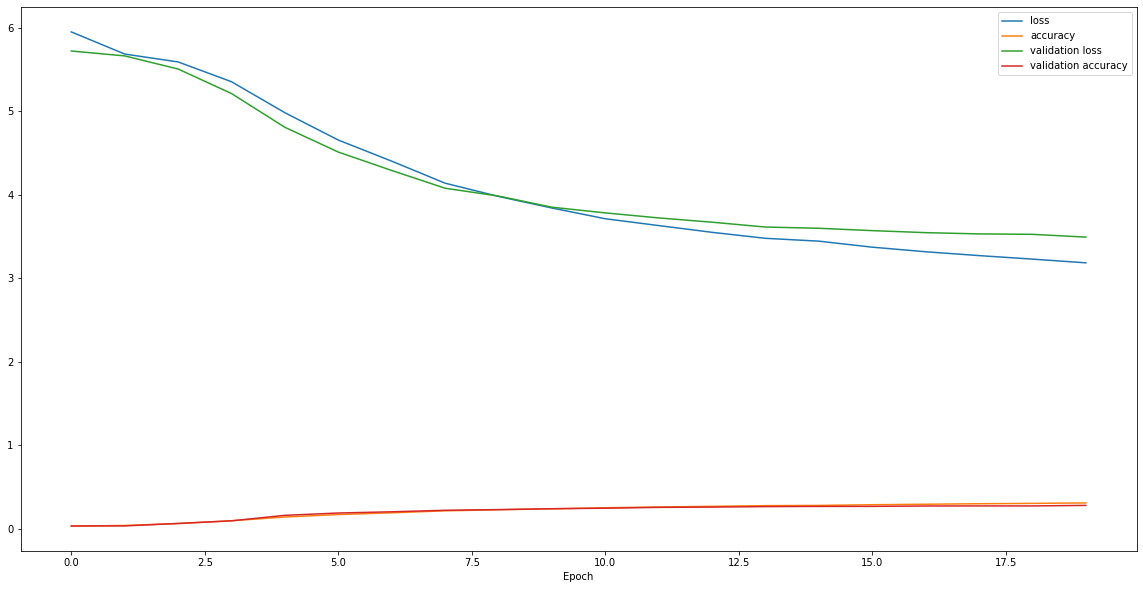

In [9]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist.history["loss"], label='loss')
ax.plot(hist.history["accuracy"], label='accuracy')
ax.plot(hist.history["val_loss"], label='validation loss')
ax.plot(hist.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [10]:
# Zusatz
input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(X_train[0])), 'blue'), "\n", "-"*40)
print("Expected result:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(y_train[0])), 'green'), "\n", "-"*40)
print("Trained prediction:", "\n", "-" * 40, "\n", colored(untokenize(one_hot.decode(example_batch_predictions[0])), 'red'), "\n", "-"*40)

(1, 150, 2423) (150, 2423) (1, 150, 2423)
Test sequence: 
 ---------------------------------------- 
  "$60,000" 
MAN: "OK, but for that price I want it with all the options." 
WOMAN: "Great! Oh, and one more thing...the house we wanted last year is back on the market. They're asking $950,000." 
MAN: "Well, then go ahead and give them an offer, but just offer $900,000." 
WOMAN: "OK. I'll see you lat 
 ----------------------------------------
Expected result: 
 ---------------------------------------- 
 $60,000" 
MAN: "OK, but for that price I want it with all the options." 
WOMAN: "Great! Oh, and one more thing...the house we wanted last year is back on the market. They're asking $950,000." 
MAN: "Well, then go ahead and give them an offer, but just offer $900,000." 
WOMAN: "OK. I'll see you later 
 ----------------------------------------
Trained prediction: 
 ---------------------------------------- 
 Oh0,000 " 
"N: "I , I t yor a e  tolva.  wast to aash a l the coenng t" ThomAN: A e

TODO Was hat er gelernt?

- Großschreibung nach Punkte
- Wörter
- ....

## x.5 Text prediction

(1) Schreiben Sie eine Methode, die für einen gegebenen Text das nächste Zeichen prognostiziert

In [11]:
def predict(txt, one_hot, trainied_model):
    encoded_txt = one_hot.encode(tokenize(txt))
    prediction = trainied_model.predict(encoded_txt.reshape((1, *encoded_txt.shape)))
    return untokenize(one_hot.decode(prediction[0]))[-1]

(2) *Optional:* Nutzen Sie ipywidgets um live vorschläge zurück zu geben

In [12]:
import ipywidgets as widgets
from IPython.display import display

test_cases = ["spo", "foo", "jok"]

In [13]:
def verbose_prediction(txt, one_hot, trainied_model):
    if len(txt) == 0:
        txt = " "
    prediction = predict(txt=txt, one_hot=one_hot, trainied_model=trainied_model)
    print(f"I think the next will be \"{prediction}\" after you said \"{txt}\"")

w = widgets.interactive(verbose_prediction,
                        txt=widgets.Text(value='Hello Worl', placeholder='Type something', description='Your text:', disabled=False),
                        one_hot=widgets.fixed(one_hot),
                        trainied_model=widgets.fixed(model),
                       )

for test_case in test_cases:
    verbose_prediction(test_case, one_hot=one_hot, trainied_model=model)

display(w)

I think the next will be "e" after you said "spo"
I think the next will be " " after you said "foo"
I think the next will be " " after you said "jok"


interactive(children=(Text(value='Hello Worl', description='Your text:', placeholder='Type something'), Output…

## x.6 *Optional* Vergleich mit LSTM und GRU und ...

Trainieren Sie nun modelle mit LSTM und GRU oder anderen Architekturen und vergleichen Sie lernperformance und Ergebnisse. Was fällt Ihnen auf?

In [14]:
with strategy.scope() if strategy is not None else open("/dev/null"):
    model_lstm = tf.keras.Sequential(name="LSTM_Model")
    model_lstm.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, name="The_Brain"))
    model_lstm.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_lstm.build(input_shape=(None, *input_shape))
    model_lstm.summary()

    model_gru = tf.keras.Sequential(name="GRU_Model")
    model_gru.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, name="The_Brain"))
    model_gru.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
    model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_gru.build(input_shape=(None, *input_shape))
    model_gru.summary()


Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, None, 1024)        14123008  
_________________________________________________________________
The_Hand (Dense)             (None, None, 2423)        2483575   
Total params: 16,606,583
Trainable params: 16,606,583
Non-trainable params: 0
_________________________________________________________________
Model: "GRU_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, None, 1024)        14123008  
_________________________________________________________________
The_Hand (Dense)             (None, None, 2423)        2483575   
Total params: 16,606,583
Trainable params: 16,606,583
Non-trainable params: 0
_________________________________________________________________


In [15]:
t1 = time.time()
hist_lstm = model_lstm.fit(ds_train,
                           epochs=EPOCHS,
                           validation_data=ds_val)
t2 = time.time()
t_lstm = t2 - t1

t1 = time.time()
hist_gru = model_gru.fit(ds_train,
                         epochs=EPOCHS,
                         validation_data=ds_val)
t2 = time.time()
t_gru = t2 - t1

print("LSTM Training took:", timedelta(seconds=t_lstm))
print("GRU  Training took:", timedelta(seconds=t_gru))

Epoch 1/20
38/38 [==============================] - 17s 225ms/step - loss: 6.4586 - accuracy: 0.0279 - val_loss: 5.7056 - val_accuracy: 0.0322
Epoch 2/20
38/38 [==============================] - 7s 184ms/step - loss: 5.6845 - accuracy: 0.0332 - val_loss: 5.6512 - val_accuracy: 0.0432
Epoch 3/20
38/38 [==============================] - 7s 184ms/step - loss: 5.6276 - accuracy: 0.0405 - val_loss: 5.5841 - val_accuracy: 0.0510
Epoch 4/20
38/38 [==============================] - 7s 184ms/step - loss: 5.5507 - accuracy: 0.0634 - val_loss: 5.4661 - val_accuracy: 0.0945
Epoch 5/20
38/38 [==============================] - 8s 208ms/step - loss: 5.4066 - accuracy: 0.0984 - val_loss: 5.2487 - val_accuracy: 0.1105
Epoch 6/20
38/38 [==============================] - 7s 185ms/step - loss: 5.1657 - accuracy: 0.1228 - val_loss: 4.9767 - val_accuracy: 0.1389
Epoch 7/20
38/38 [==============================] - 7s 184ms/step - loss: 4.8883 - accuracy: 0.1480 - val_loss: 4.7274 - val_accuracy: 0.1606
Epoch

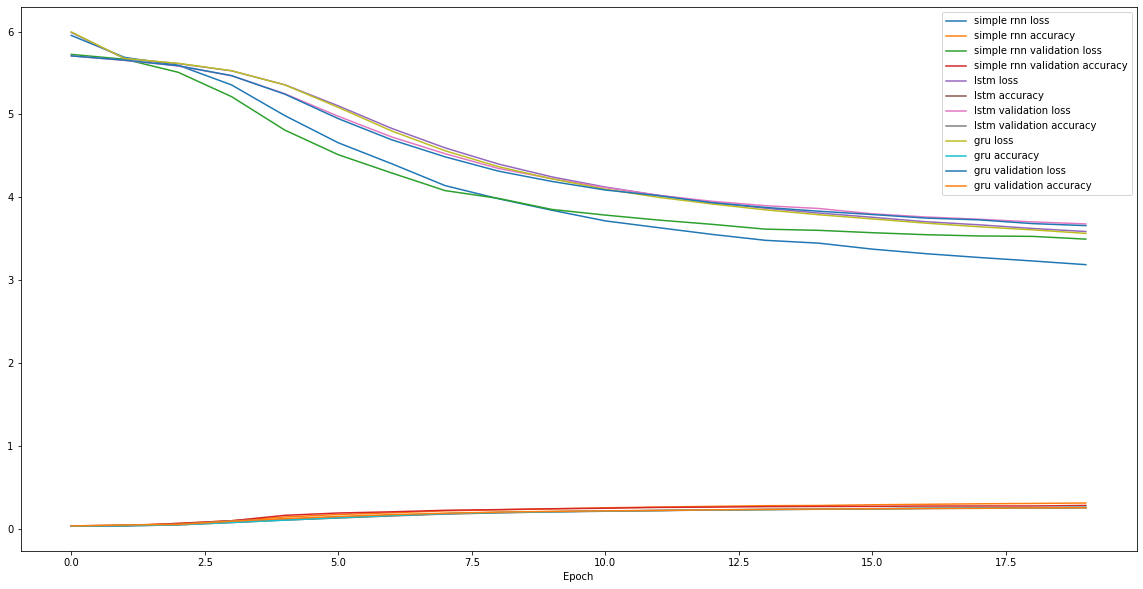

---------- SimpleRNN ----------
I think the next will be "e" after you said "spo"
I think the next will be " " after you said "foo"
I think the next will be " " after you said "jok"
---------- LSTM ----------
I think the next will be "r" after you said "spo"
I think the next will be " " after you said "foo"
I think the next will be " " after you said "jok"
---------- GRU ----------
I think the next will be "n" after you said "spo"
I think the next will be " " after you said "foo"
I think the next will be " " after you said "jok"


In [16]:
fig, ax = plt.subplots(1, 1)

for n, h in [("simple rnn", hist), ("lstm", hist_lstm), ("gru", hist_gru)]:

    ax.plot(h.history["loss"], label=f'{n} loss')
    ax.plot(h.history["accuracy"], label=f'{n} accuracy')
    ax.plot(h.history["val_loss"], label=f'{n} validation loss')
    ax.plot(h.history["val_accuracy"], label=f'{n} validation accuracy')

ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

print("-" * 10, "SimpleRNN", "-" * 10)
for test_case in test_cases:
    verbose_prediction(test_case, one_hot=one_hot, trainied_model=model)

print("-" * 10, "LSTM", "-" * 10)
for test_case in test_cases:
    verbose_prediction(test_case, one_hot=one_hot, trainied_model=model_lstm)

print("-" * 10, "GRU", "-" * 10)
for test_case in test_cases:
    verbose_prediction(test_case, one_hot=one_hot, trainied_model=model_gru)

## x.7 *Noch Optionaler* Ist das Netz jetzt ein Schriftsteller?

Was müsste man ändern um nun ein ganzes Buch erstellen zu lassen? Glauben Sie das Ergebniss wäre lesbar?

Vor allem hier wird es wahrscheinlich nötig sein deutlich mehr Trainingsdaten und mehr trainingsepochen zur Verfügung zu stellen

Hierfür wollen wir wenn möglich beliebig viele Zeichen generieren, dabei den hidden state behalten und nicht konstant das bisher geschriebene als Input wieder einfügen. Deshalb nutzen wir hier eine eigene Klasse für das Netz, die dann die Layer enthält, aber aich den Hidden state zurück geben kann

In [17]:
EPOCHS = 50

text = "\n\n".join(jokes)
tokens = sorted(set(text + " "))
one_hot = OneHot(tokens=tokens)
coded_text = one_hot.encode(text)
coded_text_seq = sequenze_split(coded_text, sequence_len)
X = coded_text_seq[:, :-1]
y = coded_text_seq[:, 1:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size)
ds_train = create_dataset_from_data(X_train, y_train)
ds_val = create_dataset_from_data(X_val, y_val)

vocab_size = X_train.shape[-1]

In [18]:
class CustomRNNModel(tf.keras.Model):
    def __init__(self, vocab_size, rnn_units, rnn_layer_type = tf.keras.layers.GRU):
        super().__init__(self)
        # Put layers here. We will call them manually but store them here
        self.rnn_layer = rnn_layer_type(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, states=None, return_state=False, training=False):
        # Here we put our input through all out layers
        x = tf.cast(inputs, dtype=float)
        if states is None:
            # Get an initial kind of empty state
            states = self.rnn_layer.get_initial_state(x)
        
        x, states = self.rnn_layer(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [19]:
with strategy.scope() if strategy is not None else open("/dev/null"):
    literatur_model = CustomRNNModel(vocab_size=vocab_size, rnn_units=rnn_units)
    literatur_model.build(input_shape=(None, None, vocab_size))
    literatur_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

literatur_model.summary()

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = literatur_model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

Model: "custom_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  3511296   
_________________________________________________________________
dense (Dense)                multiple                  119925    
Total params: 3,631,221
Trainable params: 3,631,221
Non-trainable params: 0
_________________________________________________________________
(1, 150, 117) (150, 117) (1, 150, 117)
Test sequence: 
 ------------------------- 
 dserve without dressing. So I didn't dress. What asurprise when Bob brought a friend home for supper. WEDNESDAY:A good day for rice. The recipe said w 
 -------------------------
Expected result: 
 ------------------------- 
 serve without dressing. So I didn't dress. What asurprise when Bob brought a friend home for supper. WEDNESDAY:A good day for rice. The recipe said wa 
 -------------------------
Untrained pre

In [ ]:
t1 = time.time()
hist_custom = literatur_model.fit(ds_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=ds_val)
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Epoch 1/50
171/171 [==============================] - 18s 80ms/step - loss: 3.4760 - accuracy: 0.1853 - val_loss: 2.4059 - val_accuracy: 0.3358
Epoch 2/50
171/171 [==============================] - 13s 75ms/step - loss: 2.3521 - accuracy: 0.3463 - val_loss: 2.2024 - val_accuracy: 0.3712
Epoch 3/50
171/171 [==============================] - 13s 74ms/step - loss: 2.1635 - accuracy: 0.3823 - val_loss: 2.0360 - val_accuracy: 0.4146
Epoch 4/50
171/171 [==============================] - 13s 74ms/step - loss: 1.9892 - accuracy: 0.4276 - val_loss: 1.8730 - val_accuracy: 0.4607
Epoch 5/50
171/171 [==============================] - 14s 82ms/step - loss: 1.8309 - accuracy: 0.4724 - val_loss: 1.7457 - val_accuracy: 0.4976
Epoch 6/50
171/171 [==============================] - 13s 74ms/step - loss: 1.7040 - accuracy: 0.5087 - val_loss: 1.6462 - val_accuracy: 0.5254
Epoch 7/50
171/171 [==============================] - 13s 74ms/step - loss: 1.6033 - accuracy: 0.5355 - val_loss: 1.5731 - val_accuracy:

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist_custom.history["loss"], label='loss')
ax.plot(hist_custom.history["accuracy"], label='accuracy')
ax.plot(hist_custom.history["val_loss"], label='validation loss')
ax.plot(hist_custom.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [ ]:
def create_text(amount_symbols, init_text, text_model):    
    # Tokenize text
    ret = tokenize(init_text)
    
    states = None
    current_char = one_hot.encode(ret, dtype=float)
    # For some reason we have to add one dimension
    current_char = current_char.reshape(1, *current_char.shape)
    
    for i in range(amount_symbols):
        current_char, states = text_model(current_char, return_state = True, states = states)
        # Only add last char if several got 
        ret.append(one_hot.decode(current_char[0])[-1])
        
    return untokenize(ret)
    

In [ ]:
created_text = create_text(250, "Sport", literatur_model)

print(created_text)